In [1]:
########################################
# Keras
########################################
from keras.models import load_model                                                                     # load up models from file
from keras import Model, Input                                                                          # major classes
from keras.layers import Dense, Flatten, Dropout, LeakyReLU, BatchNormalization, Softmax, Embedding     # layers
from keras.losses import categorical_crossentropy, mean_squared_error                                   # cost functions
from keras.optimizers import Adam                                                                       # optimizer
from keras.regularizers import l1, l2                                                                   # regularizers
from keras.initializers import glorot_normal                                                            # for normalization

########################################
# Preparing data
########################################
from sklearn.model_selection import train_test_split # split into training and testing data

# common packages
from multiprocessing import Pool
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle

Using TensorFlow backend.
/Users/CCCP/creamy_seas/sync_files/python_vi/pro_vi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/CCCP/creamy_seas/sync_files/python_vi/pro_vi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/CCCP/creamy_seas/sync_files/python_vi/pro_vi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

# Full workflow for the following NN
<center>The origin of the data and what is means will be coverd in <a href="material_encodingData_notebook.ipynb"><b>Encoding Notebook</b></a></center>

<img src="images_inkscape/simple_model_v2.png" style="width: 1000px;">

# 1 ⦿ Prepare training data

In [2]:
########################################
# 1 - load in the input data
########################################
with open("language_data.pkl", 'rb') as fin:
    data = pickle.load(fin)
X_raw = data['X-input']
Y_raw = data['Y-output']

########################################
# 2 - split into training and testing
########################################
(X_train, X_test,
 Y_train, Y_test) = train_test_split(X_raw,
                                     Y_raw,
                                     test_size = 0.02, random_state=42, shuffle=True)

# 2 🏗 Build the model

In [3]:
lambd = 0.03
dropout_rate = 0.3

########################################
# 3 - construct the layers
########################################
number_of_input_nodes = (X_train.shape[1] * X_train.shape[2])
INPUTS = Input((X_train.shape[1], X_train.shape[2]))
FLATTENED = Flatten(name="flatten_inputs")(INPUTS)
PROPAGATING_LAYER = BatchNormalization(name="batchNorm_inputs")(FLATTENED)
PROPAGATING_LAYER = Dense(5 * number_of_input_nodes, name="1_dense",
                          kernel_initializer=glorot_normal(seed=random.randint(1, 10000)),
                          kernel_regularizer=l2(lambd))(PROPAGATING_LAYER)
PROPAGATING_LAYER = Dropout(dropout_rate, name="1_dropout")(PROPAGATING_LAYER)
PROPAGATING_LAYER = BatchNormalization(name="1_batch")(PROPAGATING_LAYER)
PROPAGATING_LAYER = LeakyReLU(0.1, name='1_activation')(PROPAGATING_LAYER)
PROPAGATING_LAYER = Dense(5 * number_of_input_nodes, name="2_dense",
                          kernel_initializer=glorot_normal(seed=random.randint(1, 10000)),
                          kernel_regularizer=l2(lambd))(PROPAGATING_LAYER)
PROPAGATING_LAYER = BatchNormalization(name="2_batch")(PROPAGATING_LAYER)
PROPAGATING_LAYER = LeakyReLU(0.1, name='2_activation')(PROPAGATING_LAYER)
OUTPUT_LAYER = Dense(Y_train.shape[1])(PROPAGATING_LAYER)

########################################
# 4 - compile the model
########################################
learning_rate = 0.0001
beta_1 = 0.85
beta_2 = 0.99
adam_tuned = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)           # 🐋🐋🐋 custom now
model = Model(inputs=INPUTS, outputs=OUTPUT_LAYER)
model.compile(loss=mean_squared_error, optimizer=adam_tuned)
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15, 26)            0         
_________________________________________________________________
flatten_inputs (Flatten)     (None, 390)               0         
_________________________________________________________________
batchNorm_inputs (BatchNorma (None, 390)               1560      
_________________________________________________________________
1_dense (Dense)              (None, 1950)              762450    
_________________________________________________________________
1_dropout (Dropout)          (None, 1950)              0         
_________________________________________________________________
1_batch (BatchNormalization) (None, 1950)              7800      
____

# 3 🚆 train the model

Train on 106996 samples, validate on 1081 samples
Epoch 1/4
106996/106996 [==============================] - 20s 188us/step - loss: 57.8910 - val_loss: 39.9987
Epoch 2/4
106996/106996 [==============================] - 21s 194us/step - loss: 28.7871 - val_loss: 19.2567
Epoch 3/4
106996/106996 [==============================] - 22s 205us/step - loss: 13.4873 - val_loss: 8.6407
Epoch 4/4
106996/106996 [==============================] - 22s 206us/step - loss: 5.8157 - val_loss: 3.4885


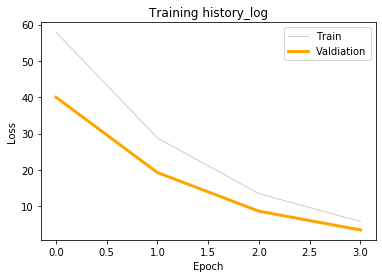

In [4]:
epochs = 4
batch_size = 1024

history_log = model.fit(X_train, Y_train,
                        verbose=1, epochs=epochs,
                        batch_size=batch_size, validation_split=0.01)

# 7 - print result
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(history_log.history["loss"], color='grey', linewidth=1, alpha=0.4)
ax.plot(history_log.history["val_loss"], color="orange", linewidth=3)
ax.set_title("Training history_log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(["Train", "Valdiation"])

plt.show()

# 4 🔐 save the model

In [ ]:
def save_nn(model, metadata, data, save_name, save_folder="trained_nn"):
    """
    __ Parameters __
    [ks.model] model:           to save
    [dictionary] metadata:      dictionary with the metadata on the nn
    [dictionary] data:          train and test data
    [str] save_name:            name to save nn under
    [str] save_folder:          folder where to save nn

    __ Description __
    Save the model and its metadata for future use
    """
    # 1 - create folder to store the nn
    if not os.path.exists(f"./{save_folder}"):
        os.makedirs(save_folder)
    # 2 - save the model
    model.save(f"{save_folder}/{save_name}.nn")
    # 3 - save metadata of the model
    with open(f"{save_folder}/{save_name}_metadata.pkl", 'wb') as fout:
        pickle.dump(metadata, fout)
    # 4 - save training and testing data
    with open(f"{save_folder}/{save_name}_data.pkl", 'wb') as fout:
        pickle.dump(data, fout)
        
        
def load_nn(save_name, save_folder="trained_nn"):
    """
    __ Parameters __
    [str] save_name:            name the nn was saved under
    [str] save_folder:          folder nn is in

    __ Description __
    Load the model and metadata

    __ Returns __
    [model] with the initialized weights from the file
    [dictionary] metadata on the model
    """

    # 1 - load the model
    model = load_model(f"./{save_folder}/{save_name}.nn")
    # 2 - load the metadata
    with open(f'{save_folder}/{save_name}_metadata.pkl', 'rb') as fin:
        metadata = pickle.load(fin)
    # 3 - load training and testing data
    with open(f'{save_folder}/{save_name}_data.pkl', 'rb') as fin:
        data = pickle.load(fin)
        
    return model, metadata, data

In [ ]:
########################################
# 1 - generate a list of metadata for the model
########################################
metadata = {"X-train_dim": X_train.shape,
            "Y-train_dim": Y_train.shape,
            # anything else which would be required to recreate the model
}
train_test_data = {"X-train": X_train,
                       "X-test": X_test,
                       "Y-train": Y_train,
                       "Y-test": Y_test}
########################################
# 2 - save
########################################
save_nn(model, metadata, train_test_data, "language_v1")

# 5 ⏰  Test the model

In [50]:
########################################
# 1 - imagine some time has passed, or testing is perfromed on a different computer
########################################
model, metadata, data = load_nn("language_v1")

X_test = data['X-test']
Y_test = data['Y-test']

# 1 - run prediction
prediction = model.predict(X_test)

########################################
# 2 -  find how many of the predictions were correct
########################################
prediction_mostLikely = np.argmax(prediction, axis=1)
error_array = np.argmax(Y_test, axis=1) - prediction_mostLikely
error_indicies = np.nonzero(error_array)[0]

print(f"⦿  {len(error_indicies) / len(X_test) * 100:.2f}% error - {len(error_indicies)}/{len(X_test)} samples")

⦿  37.40% error - 825/2206 samples
